In [1]:
import os

import numpy as np
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file, read_predictions_from_file

----

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
# task = "rte"
task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False


## Plot t-SNE embeddings

In [22]:
# RTE patterns
# use_pattern = [
#     "null_pattern",
#     "null_pattern_reversed",
#     "gpt_3_yes_no",
#     "gpt_3_yes_no_shuffled",
#     "gpt_3_true_false",
#     "gpt_3_true_false_shuffled",
#     "start_with_the",
#     "mnli_crowdsource",
#     "based_on_previous_passage",
#     "infer",
#     "follow",
#     "imply",
#     "guaranteed",
#     "justified", 
#     "must_be_true",
#     "should_assume"
# ]

# CB patterns
use_pattern = [
    "null_pattern",
    "null_pattern_reversed",
    "gpt_3_true_false_neither",
    "gpt_3_yes_no_maybe",
    "mnli_crowdsource",
    "always_sometimes_never",
    "based_on_previous_passage",
    "infer",
    "claim",
    "consider",
    "follow",
    "imply",
    "guaranteed",
    "guaranteed_possible",
    "justified",
    "must_be_true",
    "should_assume",
    "take_the_following",
]

# WIC patterns
# use_pattern = [
#     "gpt_3",
#     "gpt_3_yes_no",
#     "affirmation",
#     "grammar_homework",
#     "polysemous",
#     "question_context",
#     "question_meaning",
#     "question_meaning_yes_no",
#     "same_sense",
#     "similar_sense",
#     "similar_sense_yes_no",
# ]

(1008, 2048)


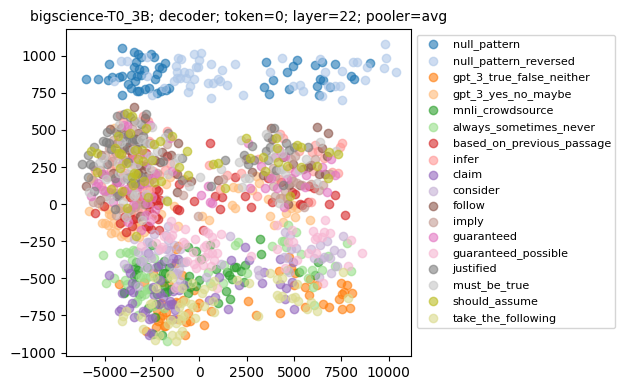

(1008, 2048)


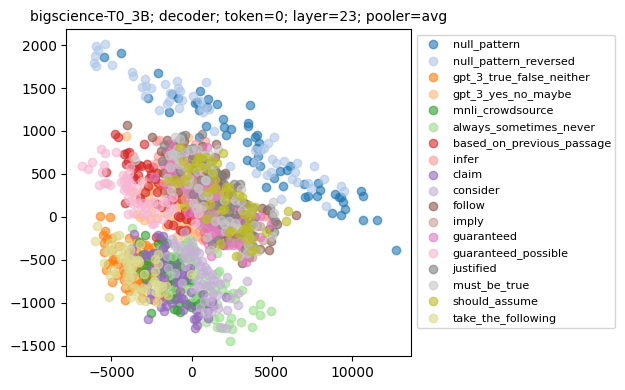

(1008, 2048)


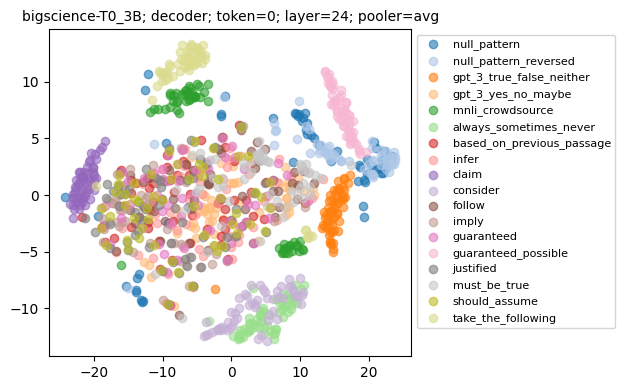

(1008, 2048)


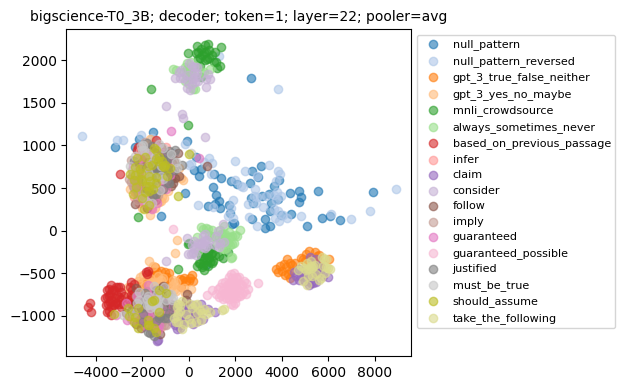

(1008, 2048)


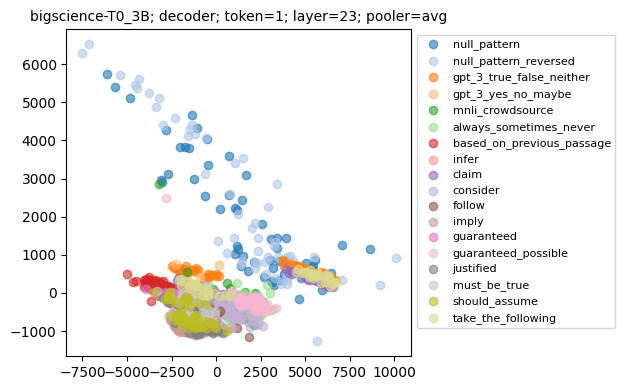

(1008, 2048)


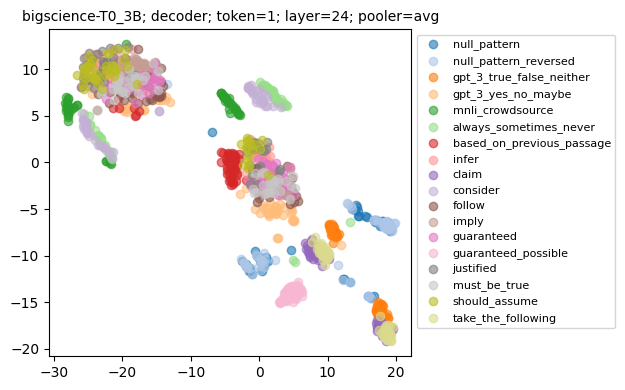

In [23]:
# For decoder representations we need to additionally specify the generated token
# We currently save representations for t=0 and t=1
for t in range(2):
    # for layer in range(0, 1):
    # for layer in range(0, 5):
    # for layer in range(0, 25):
    for layer in range(22, 25):
        
        file_names, prompt_names = [], []

        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5")
                prompt_names.append(row['name'])
        
        # load hidden representations from hdf5 file
        representations = None
        n_sequences = 0

        for file_name in file_names:
            hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
            n_sequences = hidden_representations.shape[0]

            if representations is None:
                representations = hidden_representations
            else:
                representations = np.concatenate((representations, hidden_representations), axis=0)

        print(representations.shape)

        # compute t-SNE embeddings
        X = TSNE(
            n_components=2, 
            perplexity=100, 
            init='pca', # random or pca
            learning_rate=100,
            n_iter=1000
        ).fit_transform(representations)

        # plot t-SNE embeddings
        fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)

        cmap = matplotlib.cm.get_cmap('tab20')
        colors = cmap.colors

        for idx, file_name in enumerate(file_names):
            axes.scatter(X[n_sequences*idx:n_sequences*(idx + 1), 0], X[n_sequences*idx:n_sequences*(idx + 1), 1], alpha=0.6, color=colors[idx], label=prompt_names[idx])

        axes.set_title(f"{model}; {module}; token={t}; layer={layer}; pooler=avg", fontsize=10)

        # Shrink current axis by 20%
        box = axes.get_position()
        axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        axes.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

        plt.tight_layout()

        plt.show()
        plt.close();

In [24]:
df

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False


In [25]:
df[df['name'] == 'consider']['template'].values

array(['{premise} Keeping in mind the above text, consider: {hypothesis} Is this Always, Sometimes, or Never correct?'],
      dtype=object)

In [26]:
# get predictions
predictions = {}

for idx, row in df.iterrows():
    file_name = f"{task}/{model}/{module}/{row['name']}/decoded_predictions.csv"
    preds_df = read_predictions_from_file(os.path.join(log_dir, file_name))
    predictions[row['name']] = preds_df

In [27]:
predictions['null_pattern'].head()

,predicted_sequence
0,"['<pad>', '▁Val', 'ence']"
1,"['<pad>', '▁yes', '</s>']"
2,"['<pad>', '▁The', '▁writer']"
3,"['<pad>', '▁not', '▁drug']"
4,"['<pad>', '▁A', ':']"


In [28]:
predictions['gpt_3_yes_no_maybe'].head()

,predicted_sequence
0,"['<pad>', '▁No', '</s>']"
1,"['<pad>', '▁Yes', '</s>']"
2,"['<pad>', '▁Yes', '</s>']"
3,"['<pad>', '▁Yes', '</s>']"
4,"['<pad>', '▁Maybe', '</s>']"


In [29]:
predictions['guaranteed_possible'].head()

,predicted_sequence
0,"['<pad>', '▁Possible', '</s>']"
1,"['<pad>', '▁Possible', '</s>']"
2,"['<pad>', '▁Possible', '</s>']"
3,"['<pad>', '▁Possible', '</s>']"
4,"['<pad>', '▁Possible', '</s>']"
